In [1]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.colors import BoundaryNorm
%matplotlib inline

## MEDIDAS COM TEMPO ABAIXO DE 8us (STOPPING MUONS) x ACIMA (RUÍDOS)

In [2]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [3]:

# para 4 x 7 dias

list_ON1 = ['20200820','20200821','20200822','20200823','20200824','20200825','20200826']
list_ON2 = ['20200827','20200828','20200829','20200830','20200831','20200901','20200902']
list_ON3 = ['20200903','20200904','20200905','20200906','20200907','20200908','20200909']
list_ON4 = ['20200910','20200911','20200912','20200913','20200924','20200925','20200926']
#           '20200927','20200928'

list_OFF1 = ['20200624','20200625','20200626','20200627','20200628','20200629','20200630']
list_OFF2 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707']
list_OFF3 = ['20200708','20200709','20200710','20200711','20200712','20200713','20200714']
list_OFF4 = ['20200715','20200716','20200717','20200718','20200719','20200720','20200721']
#            '20200722','20200723'

list_ONO1 = ['20201001','20201002','20201003','20201004','20201005','20201006','20201007']
list_ONO2 = ['20201008','20201009','20201010','20201011','20201012','20201013','20201014']
list_ONO3 = ['20201015','20201016','20201017','20201018','20201019','20201020','20201021']
list_ONO4 = ['20201022','20201023','20201024','20201025','20201026','20201027','20201028']
#            '20201029','20201030'


In [4]:
#chi_sq_tab = 2.366  # chi quadrado tabelado para 3 graus de liberdades com 50%
#chi_sq_tab = 6.251  # chi quadrado tabelado para 3 graus de liberdades com 90%
chi_sq_tab = 7.815  # chi quadrado tabelado para 3 graus de liberdades com 95%
#chi_sq_tab = 10.597  # chi quadrado tabelado para 3 graus de liberdades com 995%
rh, rw = 150, 150
prompt_mean, prompt_var = 61.45215100965759, 1337.7332240825515
delay_mean, delay_var = 94.3970297029703, 4899.284941672385 
time_mean, time_var = 12.70, 12.70
itime_mean, itime_var = 1/12.70, 1/(12.70**2)

IBD_Esperado = 6610 #eventos por dia


## Função para processar lista

In [22]:
def fnt_process_list_PD_3 (p_list, p_h_PDP, p_h_PDD, p_h_PDT, i_Sub): 
    #i_Sub = 1: t<=8us (sinal); i_Sub = 2: t>8us (ruído)
    
    p_totalMuons = 0
    p_totalNonSat = 0
    p_totalTime = 0
    
    print('fnt_process_list_PD_3 - v3, i_Sub = ',i_Sub)

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)

        for file in lista:
            df = pd.read_parquet(file)
            if (i_Sub==1):
                dff = df[#(df['p_Total_charge']>50000)&(df['p_Total_charge']<75000)&
                     (df['d_timeInverval']<=8)]
            else:
                dff = df[#(df['p_Total_charge']>50000)&(df['p_Total_charge']<75000)&
                     (df['d_timeInverval']>8)
                     #&(df['d_timeInverval']<12)
                ]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            
            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalMuons += df.count()[0]
            p_totalNonSat += dfns.count()[0]
            p_totalTime += df['d_timeInverval'].sum()

            #break

    return p_totalMuons, p_totalNonSat, p_totalTime


## Salvar e carregar Listas ON / OFF

In [23]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_PDD, dh_PDT, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_PDD': dh_PDD,
            'dh_PDT': dh_PDT}
    
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_DPMT, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_PDD'].values, dfr['dh_PDT'].values)

    

## Processamento para OFF1

In [24]:
print('Inicio - Sinal',datetime.datetime.now())

h_PDP_OFF1 = []
h_PDD_OFF1 = []
h_PDT_OFF1 = []
totalMuons_OFF1 = 0
totalNonSat_OFF1 = 0
totalTime_OFF1 = 0

list_OFF1 = ['20200701']
totalMuons_OFF1, totalNonSat_OFF1, totalTime_OFF1 = fnt_process_list_PD_3(list_OFF1, h_PDP_OFF1, h_PDD_OFF1, h_PDT_OFF1, 1)
                            
print(len(h_PDP_OFF1))
print('Em ',len(list_OFF1),' dias: ',totalMuons_OFF1)
print('Por dia: ',totalMuons_OFF1/len(list_OFF1))
print('Em ',len(list_OFF1),' dias (NS): ',totalNonSat_OFF1)
print('Por dia (NS): ',totalNonSat_OFF1/len(list_OFF1))
print('Tempo (em s): ',totalTime_OFF1/1000)

        
print('Fim',datetime.datetime.now())

Inicio - Sinal 2024-01-31 13:56:08.540042
fnt_process_list_PD_3 - v3, i_Sub =  1
data/20200701
93436
Em  1  dias:  16823250
Por dia:  16823250.0
Em  1  dias (NS):  10588204
Por dia (NS):  10588204.0
Tempo (em s):  86158196.422512
Fim 2024-01-31 14:00:43.598673


In [25]:
print('Inicio - Ruído - OFF',datetime.datetime.now())

h_PDP_OFF2 = []
h_PDD_OFF2 = []
h_PDT_OFF2 = []
totalMuons_OFF2 = 0
totalNonSat_OFF2 = 0
totalTime_OFF2 = 0

list_OFF2 = ['20200701','20200702','20200703']
totalMuons_OFF2, totalNonSat_OFF2, totalTime_OFF2 = fnt_process_list_PD_3(list_OFF2, h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, 2)
                            
print(len(h_PDP_OFF2))
print('Em ',len(list_OFF2),' dias: ',totalMuons_OFF2)
print('Por dia: ',totalMuons_OFF2/len(list_OFF2))
print('Em ',len(list_OFF2),' dias (NS): ',totalNonSat_OFF2)
print('Por dia (NS): ',totalNonSat_OFF2/len(list_OFF2))
print('Tempo (em s): ',totalTime_OFF2/1000)

        
print('Fim',datetime.datetime.now())

Inicio - Ruído - OFF 2024-01-31 14:00:55.940837
fnt_process_list_PD_3 - v3, i_Sub =  2
data/20200701
data/20200702
data/20200703
49427603
Em  3  dias:  49697222
Por dia:  16565740.666666666
Em  3  dias (NS):  31875506
Por dia (NS):  10625168.666666666
Tempo (em s):  256677010.80521592
Fim 2024-01-31 14:15:55.333171


In [26]:
print('Fator tempo: ',totalTime_OFF2/totalTime_OFF1)


Fator tempo:  2.979136303486381


## Análises

## Sem normalização (somente multiplicado por fator 3 no sinal)

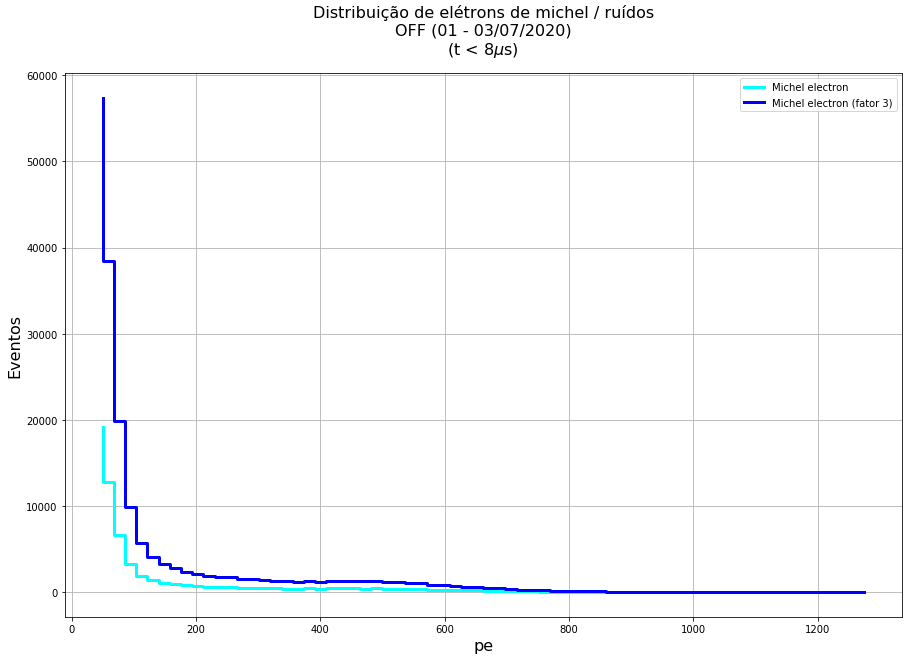

10pe =  0.997 MeV
50pe =  2.505 MeV
100pe =  4.39 MeV
150pe =  6.2749999999999995 MeV
200pe =  8.159999999999998 MeV


In [51]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

histograma1_1_1,steps1_1_1 = np.histogram(h_PDD_OFF1,bins=np.arange(50,1300,18)) #, density=True)
histograma1_1 = 3*histograma1_1_1  ## fator 3 (o correto seria 2.98, referente ao tempo_ruido/tempo_sinal)
histograma1_2,steps1_2 = np.histogram(h_PDD_OFF2,bins=np.arange(50,1300,18)) #, density=True)
#plt.step(steps1_1[:-1], 3*histograma1_1-histograma1_2, label='ON Delay (Michel electron)',color='red', linewidth=3)
plt.step(steps1_1[:-1], histograma1_1_1, label='Michel electron',color='cyan', linewidth=3)
plt.step(steps1_1[:-1], histograma1_1, label='Michel electron (fator 3)',color='blue', linewidth=3)
#plt.step(steps1_2[:-1], histograma1_2, label='Background',color='green', linewidth=3)

plt.ylabel('Eventos', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)
#plt.ylim(0,150)

plt.title('Distribuição de elétrons de michel / ruídos\n'+
          'OFF (01 - 03/07/2020)\n'+
          r'(t < 8$\mu$s)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Muons_ON_OFF_10d.png')
plt.savefig('histogramas/Hist_Michel_1d_time.png')
plt.show()

#print('max pe ON = ',max(h_PDP_ON1))
#print('max pe OFF = ',max(h_PDP_OFF1))
print('10pe = ',fnt_pe2MeV(10),'MeV')
print('50pe = ',fnt_pe2MeV(50),'MeV')
print('100pe = ',fnt_pe2MeV(100),'MeV')
print('150pe = ',fnt_pe2MeV(150),'MeV')
print('200pe = ',fnt_pe2MeV(200),'MeV')

## Sinal / Ruído

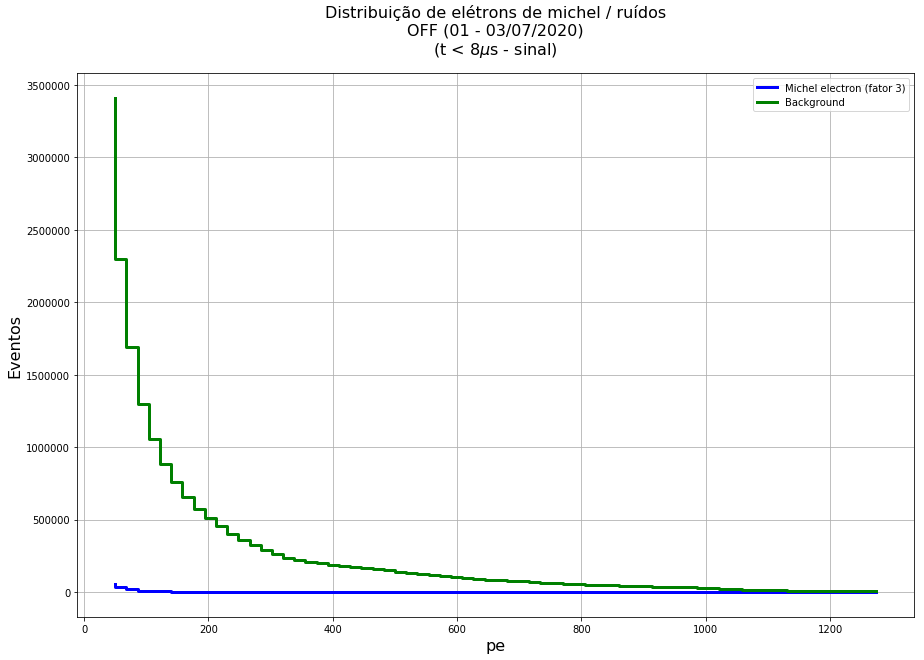

In [52]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

histograma1_1_1,steps1_1_1 = np.histogram(h_PDD_OFF1,bins=np.arange(50,1300,18)) #, density=True)
histograma1_1 = 3*histograma1_1_1  ## fator 3 (o correto seria 2.98, referente ao tempo_ruido/tempo_sinal)
histograma1_2,steps1_2 = np.histogram(h_PDD_OFF2,bins=np.arange(50,1300,18)) #, density=True)
#plt.step(steps1_1[:-1], 3*histograma1_1-histograma1_2, label='ON Delay (Michel electron)',color='red', linewidth=3)
plt.step(steps1_1[:-1], histograma1_1, label='Michel electron (fator 3)',color='blue', linewidth=3)
plt.step(steps1_2[:-1], histograma1_2, label='Background',color='green', linewidth=3)

plt.ylabel('Eventos', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)
#plt.ylim(0,150)

plt.title('Distribuição de elétrons de michel / ruídos\n'+
          'OFF (01 - 03/07/2020)\n'+
          r'(t < 8$\mu$s - sinal)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Muons_ON_OFF_10d.png')
plt.savefig('histogramas/Hist_Michel_1dx3d_time.png')
plt.show()


In [29]:
save_PD (h_PDP_OFF1, h_PDD_OFF1, h_PDT_OFF1, 'PD_OFF1_1d_Michel_v1')

In [30]:
save_PD (h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, 'PD_OFF2_3d_Michel_v1')

In [90]:
h_PDP_OFF1=[]
h_PDD_OFF1=[]
h_PDT_OFF1=[]

h_PDP_OFF1, h_PDD_OFF1, h_PDT_OFF1, = load_PD ('PD_OFF1_3d_Michel_v1')

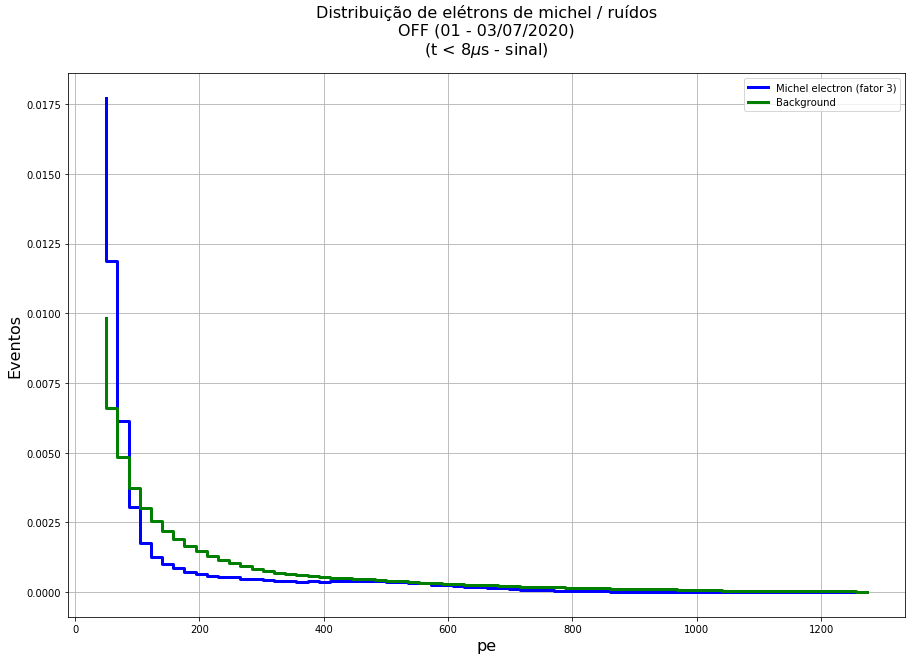

In [53]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams.update({'font.size': 10})

histograma1_1,steps1_1 = np.histogram(h_PDD_OFF1,bins=np.arange(50,1300,18), density=True)
histograma1_2,steps1_2 = np.histogram(h_PDD_OFF2,bins=np.arange(50,1300,18), density=True)
#plt.step(steps1_1[:-1], 3*histograma1_1-histograma1_2, label='ON Delay (Michel electron)',color='red', linewidth=3)
plt.step(steps1_1[:-1], histograma1_1, label='Michel electron (fator 3)',color='blue', linewidth=3)
plt.step(steps1_2[:-1], histograma1_2, label='Background',color='green', linewidth=3)

plt.ylabel('Eventos', size=16)
plt.xlabel('pe', size=16)
plt.legend(loc="upper right")
plt.grid()
#plt.xlim(0,300)
#plt.ylim(0,150)

plt.title('Distribuição de elétrons de michel / ruídos\n'+
          'OFF (01 - 03/07/2020)\n'+
          r'(t < 8$\mu$s - sinal)', size=16,y=1.02)
#plt.savefig('histogramas/Hist_Muons_ON_OFF_10d.png')
plt.savefig('histogramas/Hist_Michel_1dx3d_time_normal.png')
plt.show()